问题2b

请探索患者水肿体积随时间进展模式的个体差异，构建不同人群（分亚组：3-5 个）的水肿体积随时间进展曲线，并计算前 100 个患者（sub001 至 sub100）真实值和曲线间的残差。

问题分析：

需要根据前100个患者的个体差异数据（年龄、血压等），使用聚类方法，得到3-5个亚组。并根据不同的聚类结果分组绘制拟合曲线。

问题难点分析：

聚类所需的变量已知，但变量既有离散指标，又有连续指标，可以试试k-modes聚类，或密度聚类。

In [3]:
# 安装所需库
!pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
## 导入所需库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import kmodes

# 忽略警告
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告信息

# 设置中文字体
matplotlib.rcParams['font.family'] = 'SimHei'  # 黑体
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [118]:
## 导入数据
# 表 1 的患者个体差异数据
data1 = pd.read_csv("../处理后的数据/表1-患者列表及临床信息.csv")
df_data1 = data1[["年龄", '性别',	'脑出血前mRS评分', '高血压病史', '卒中病史', '糖尿病史', '房颤史', '冠心病史', '吸烟史', '饮酒史']]
columns = list(df_data1.columns)
for i in range(1, len(columns)):
    df_data1[columns[i]] = df_data1[columns[i]].astype("category")
print(df_data1.dtypes)
df_data1

年龄              int64
性别           category
脑出血前mRS评分    category
高血压病史        category
卒中病史         category
糖尿病史         category
房颤史          category
冠心病史         category
吸烟史          category
饮酒史          category
dtype: object


,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史
0,43,女,0,0,0,0,0,0,0,0
1,58,男,0,1,0,0,0,0,0,0
2,78,男,0,1,0,0,0,0,0,0
3,70,男,2,1,1,0,0,0,0,0
4,51,男,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
155,87,女,0,1,0,0,0,1,0,0
156,52,男,2,1,1,0,0,0,1,0
157,57,男,0,1,0,0,0,0,0,0
158,47,男,0,1,0,0,0,0,1,1


### K-modes聚类

In [ ]:
###  交叉验证选择最优聚类数
from kmodes.kmodes import KModes
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

# 将数据转换为 DataFrame
df = df_data1

def cross_validate_kmodes(X, K_range, n_splits=5):  # 定义交叉验证函数
    silhouette_scores = []  # 用于存储不同 K 值的平均轮廓系数
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # K 折交叉验证

    for k in K_range:  # k 表示当前选择的簇数
        score = 0
        valid_folds = 0  # 用于记录有效的折数
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # 切分训练集和测试集
            
            # 训练 K-Modes 模型
            km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)  # 使用 Huang 的方法初始化聚类中心  # verbose=0 表示不输出任何信息
            km.fit(X_train)
            
            # 预测测试集的标签
            labels = km.predict(X_test)
            
            # 检查聚类结果是否有效
            unique_labels = np.unique(labels)
            if len(unique_labels) == k and len(unique_labels) <= len(X_test):  # 实际的簇数是否等于k，且测试样本个数大于簇数（是为了保证轮廓系数能正常计算）
                if all(np.bincount(labels) > 0):  # 统计每个簇标签出现的次数， 确保每个簇中至少有一个样本
                    # 计算轮廓系数（注意：K-Modes 的轮廓系数计算需要转换为数值类型）
                    score += silhouette_score(
                        X_test.apply(lambda x: x.astype('category').cat.codes),  # 先转为类别编码，再转为数值编码
                        labels
                    )
                    valid_folds += 1
        
        # 如果所有折都无效，跳过该 K 值
        if valid_folds > 0:
            silhouette_scores.append(score / valid_folds)  # 计算平均轮廓系数
        else:
            silhouette_scores.append(np.nan)  # 无效 K 值记录为 NaN

    return silhouette_scores

# 计算不同 K 值的交叉验证轮廓系数
K_range = range(3, 6)  # 测试 K 值范围
scores = cross_validate_kmodes(df, K_range)

# 选择最优 K 值
valid_scores = [score for score in scores if not np.isnan(score)]  # 过滤无效的 K 值
if valid_scores:
    optimal_K = np.argmax(valid_scores) + 3  # 加 2 是因为 K_range 从 2 开始
    print(f"Optimal number of clusters (K): {optimal_K}")
else:
    print("No valid K values found. Please check the data or adjust K_range.")

Optimal number of clusters (K): 3


In [ ]:
### 重新聚类得到标签
# 训练 K-Modes 模型
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)  # 使用 Huang 的方法初始化聚类中心  # verbose=0 表示不输出任何信息
km.fit(df_data1)
labels = km.fit_predict(df_data1)

# 输出聚类标签
print("Cluster labels:", labels)

# 输出聚类中心
print("Cluster centroids:\n", km.cluster_centroids_)

df_cluster = pd.DataFrame()
df_cluster["ID"] = [f"sub{i:03d}" for i in range(1, 161)]
df_cluster["Cluster"] = labels


Cluster labels: [0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 2 2 0 0 1 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 2 1 0 0 2 0 2 0 0 2 0 0 0 0 1 2 2 0 0 0 1 0 2 1 1 1 2 1 0 0 0 1 0 0
 0 0 0 2 1 1 0 2 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 2 1 2 0 2
 1 1 1 0 0 0 0 0 1 0 2 0]
Cluster centroids:
 [['53' '男' '0' '1' '0' '0' '0' '0' '0' '0']
 ['70' '男' '0' '1' '1' '0' '0' '0' '0' '0']
 ['47' '男' '0' '1' '0' '0' '0' '0' '1' '1']]


In [84]:
df_cluster[df_cluster["Cluster"] == 2].shape

(18, 2)

In [ ]:
df_q2a = pd.read_csv("../output/df_q2a.csv")
result = pd.merge(df_q2a, df_cluster, on='ID', how='left')
result['Cluster'].value_counts()

<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume'>

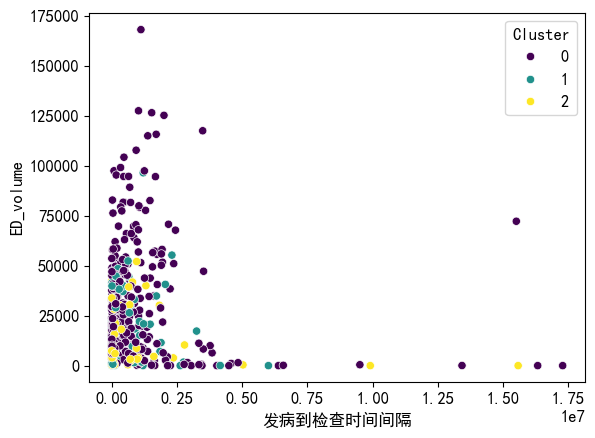

In [92]:
sns.scatterplot(data=result, x="发病到检查时间间隔", y="ED_volume", hue="Cluster", palette="viridis")

In [96]:
result1 = result[result["发病到检查时间间隔"] <= 172800]
result.shape, result1.shape

((450, 6), (212, 6))

<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume'>

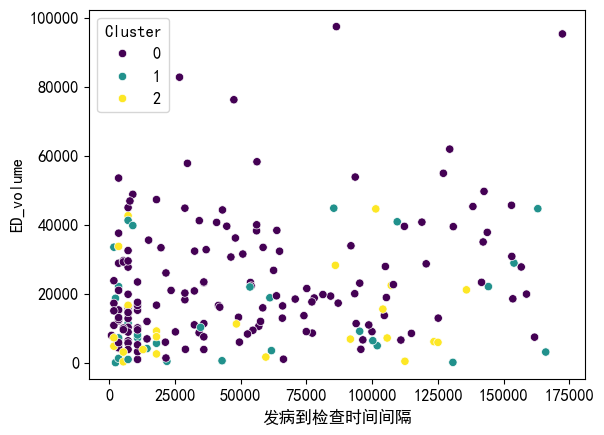

In [97]:
sns.scatterplot(data=result1, x="发病到检查时间间隔", y="ED_volume", hue="Cluster", palette="viridis")

### K-Prototypes聚类

一个针对同时具有离散变量和连续变量的聚类方法

In [98]:
df_data1.dtypes

年龄              int64
性别           category
脑出血前mRS评分    category
高血压病史        category
卒中病史         category
糖尿病史         category
房颤史          category
冠心病史         category
吸烟史          category
饮酒史          category
dtype: object

In [104]:
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score


# 确定分类变量的列索引
categorical_columns = [df.columns.get_loc(col) for col in df.select_dtypes(include=['category']).columns]

# 定义交叉验证函数
def cross_validate_kprototypes(X, K_range, categorical_columns, n_splits=5):
    silhouette_scores = []  # 用于存储不同 K 值的平均轮廓系数
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # K 折交叉验证

    for k in K_range:
        score = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            
            # 训练 K-Prototypes 模型
            kp = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=0)
            kp.fit(X_train, categorical=categorical_columns)
            
            # 预测测试集的标签
            labels = kp.predict(X_test, categorical=categorical_columns)
            
            # 计算轮廓系数（注意：K-Prototypes 的轮廓系数计算需要转换为数值类型）
            if len(set(labels)) > 1:  # 轮廓系数需要至少两个簇
                X_test_encoded = X_test.apply(lambda x: x.astype('category').cat.codes)
                score += silhouette_score(X_test_encoded, labels)
        
        silhouette_scores.append(score / n_splits)  # 计算平均轮廓系数

    return silhouette_scores

# 计算不同 K 值的交叉验证轮廓系数
K_range = range(3, 6)  # 测试 K 值范围
scores = cross_validate_kprototypes(df, K_range, categorical_columns)

# 选择最优 K 值
optimal_K = np.argmax(scores) + 3  # 加 2 是因为 K_range 从 2 开始
print(f"Optimal number of clusters (K): {optimal_K}")

Optimal number of clusters (K): 3


In [108]:
## K-Prototypes聚类
from kmodes.kprototypes import KPrototypes

df = df_data1.copy(deep=True)
# 确定离散变量的列索引
categorical_columns = [df.columns.get_loc(col) for col in df.select_dtypes(include=['category']).columns]

# 初始化K-Prototypes模型
kproto = KPrototypes(n_clusters=3, init='Cao', n_init=5, verbose=0)

# 拟合模型
clusters = kproto.fit_predict(df.values, categorical=categorical_columns)

# 将聚类结果添加到数据框中
df['Cluster'] = clusters

print("聚类结果：")
print(df)

df_cluster2 = pd.DataFrame()
df_cluster2["ID"] = [f"sub{i:03d}" for i in range(1, 161)]
df_cluster2["Cluster"] = clusters

聚类结果：
     年龄 性别 脑出血前mRS评分 高血压病史 卒中病史 糖尿病史 房颤史 冠心病史 吸烟史 饮酒史  Cluster
0    43  女         0     0    0    0   0    0   0   0        1
1    58  男         0     1    0    0   0    0   0   0        2
2    78  男         0     1    0    0   0    0   0   0        0
3    70  男         2     1    1    0   0    0   0   0        2
4    51  男         0     0    0    0   0    0   0   0        1
..   .. ..       ...   ...  ...  ...  ..  ...  ..  ..      ...
155  87  女         0     1    0    0   0    1   0   0        0
156  52  男         2     1    1    0   0    0   1   0        1
157  57  男         0     1    0    0   0    0   0   0        1
158  47  男         0     1    0    0   0    0   1   1        1
159  80  女         0     1    0    1   0    0   0   0        0

[160 rows x 11 columns]


In [109]:
result2 = pd.merge(df_q2a, df_cluster2, on='ID', how='left')
result2['Cluster'].value_counts()

Cluster
1    165
2    157
0    128
Name: count, dtype: int64

<Axes: xlabel='发病到检查时间间隔', ylabel='ED_volume'>

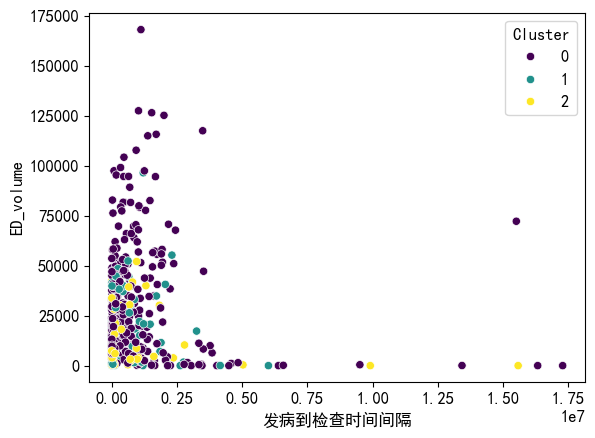

In [110]:
sns.scatterplot(data=result, x="发病到检查时间间隔", y="ED_volume", hue="Cluster", palette="viridis")

(450, 6) (212, 8)


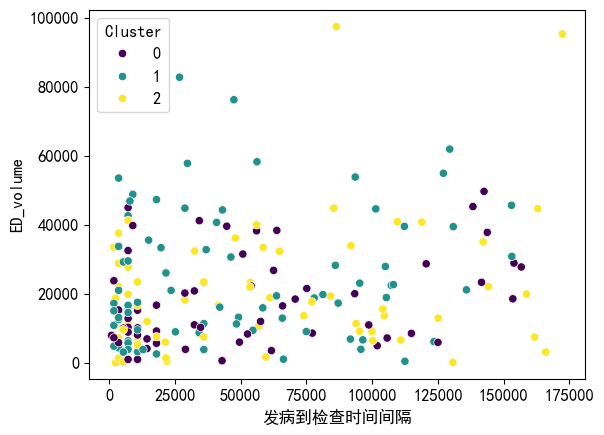

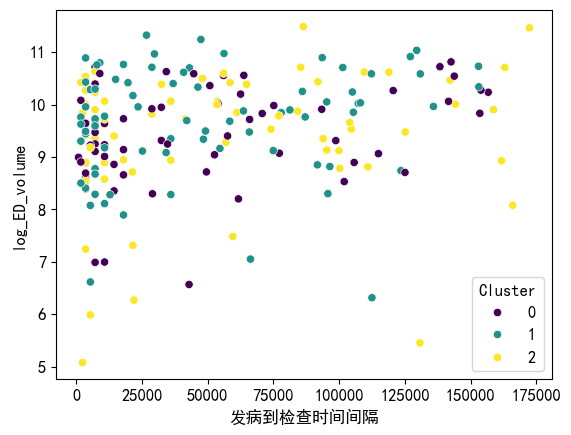

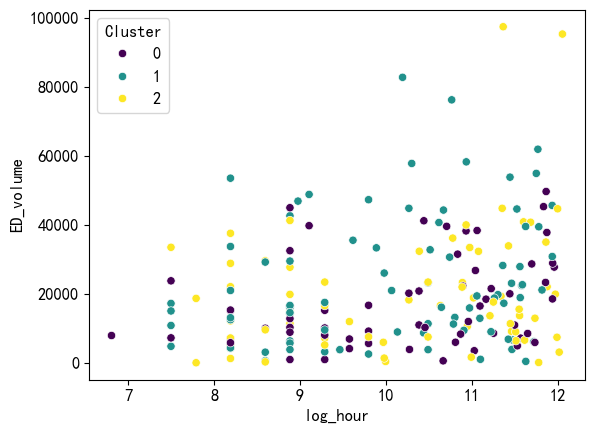

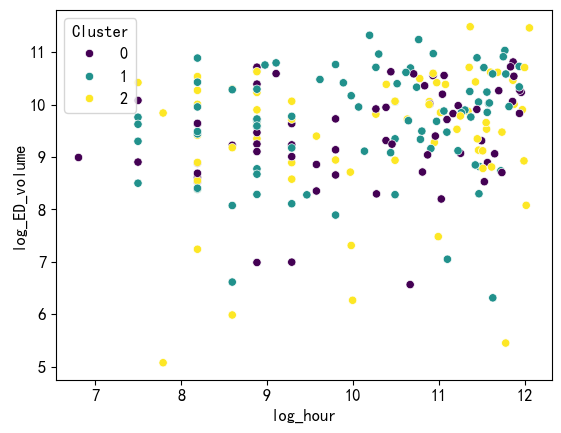

In [117]:
result21 = result2[result2["发病到检查时间间隔"] <= 172800]
result21["log_hour"] = np.log(result21["发病到检查时间间隔"].astype(float))
result21["log_ED_volume"] = np.log(result21["ED_volume"].astype(float))
print(result2.shape, result21.shape)
sns.scatterplot(data=result21, x="发病到检查时间间隔", y="ED_volume", hue="Cluster", palette="viridis")
plt.show()
sns.scatterplot(data=result21, x="发病到检查时间间隔", y="log_ED_volume", hue="Cluster", palette="viridis")
plt.show()
sns.scatterplot(data=result21, x="log_hour", y="ED_volume", hue="Cluster", palette="viridis")
plt.show()
sns.scatterplot(data=result21, x="log_hour", y="log_ED_volume", hue="Cluster", palette="viridis")
plt.show()